<a href="https://colab.research.google.com/github/KaichengDING/Triple-Defense/blob/main/idl_project_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 768kB 6.7MB/s 
     |████████████████████████████████| 7.1MB 18.7MB/s 
     |████████████████████████████████| 21.0MB 1.4MB/s 
     |████████████████████████████████| 235kB 47.7MB/s 
     |████████████████████████████████| 747kB 49.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import pandas as pd

import PIL

import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torch.utils import data

from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

import matplotlib.pyplot as plt
import time
import logging
import datetime
import random

cuda = torch.cuda.is_available()
cuda

True

In [4]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
      res = tensor + torch.randn(tensor.size()) * self.std + self.mean
      return torch.clamp(input=res, min=0.0, max=1.0)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
class VGG16(nn.Module):
    def __init__(self, nb_classes=10):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16_bn()
        self.linear = nn.Linear(1000, nb_classes)
        
    def forward(self, x):
        x = self.vgg16(x)
        x = self.linear(x)
        return x

In [7]:
class ShuffleNetV2(nn.Module):
  def __init__(self, nb_classes=10):
    super(ShuffleNetV2, self).__init__()
    self.shufflenet = models.shufflenet_v2_x2_0()
    self.linear = nn.Linear(1000, nb_classes)
        
  def forward(self, x):
    x = self.shufflenet(x)
    x = self.linear(x)
    return x

In [8]:
class ShuffleNet(nn.Module):
    def __init__(self, nb_classes =10):
        super(ShuffleNet, self).__init__()
        self.shuffle = models.shufflenet_v2_x2_0()
        self.linear = nn.Linear(1000, nb_classes)
        
    def forward(self, x):
        x = self.shuffle(x)
        x = self.linear(x)
        return x

In [9]:
# configure logging
logger = logging.getLogger("")

# reset handler
for handler in logging.root.handlers[:]:
  logging.root.removeHandler(handler)

# set handler
stream_hdlr = logging.StreamHandler()
# logging on aws ec2
# file_hdlr = logging.FileHandler('/home/ubuntu/project/logs/'.format(datetime.datetime.now()))
# logging on colab
file_hdlr = logging.FileHandler('/content/gdrive/My Drive/IDL_Project/logs/log_{}.log'.format(datetime.datetime.now()))

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
stream_hdlr.setFormatter(formatter)
file_hdlr.setFormatter(formatter)

logger.addHandler(stream_hdlr)
logger.addHandler(file_hdlr)

logger.setLevel(logging.INFO)

In [10]:
test_batchsize = 100
num_workers = 4
num_classes = 10
img_size = 224
noise_std = 0.1

device = torch.device("cuda" if cuda else "cpu")


# Get test examples

In [11]:
test_transform = transforms.Compose([transforms.Resize(size=img_size),
                     transforms.ToTensor(),
                     transforms.Normalize((0, 0, 0), (1, 1, 1))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize, shuffle=False, num_workers=num_workers, drop_last=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


# Load Saved Models

In [12]:
# models with 0.1 training noise
model_names = ['ShuffleNet_1',
               'ShuffleNet_2',
               'ShuffleNet_3',
               'ShuffleNet_4',
               'ShuffleNet_5',
               'ShuffleNet_6',
               'ShuffleNet_7',
               'ShuffleNet_8',
               'ShuffleNet_31',
               'ShuffleNet_32',
               'ShuffleNet_33',
               'ShuffleNet_34',
               'ShuffleNet_35',
               'ShuffleNet_36',
               'ShuffleNet_37',
               'ShuffleNet_38',
               'ShuffleNet_39',
               'ShuffleNet_61',
               'ShuffleNet_62',
               'ShuffleNet_63',
               'ShuffleNet_64',
               'ShuffleNet_65',
               'ShuffleNet_66',
               'ShuffleNet_67',
               'ShuffleNet_68',
               'ShuffleNet_69',
               'ShuffleNet_70',
               'ShuffleNet_71',
               'ShuffleNet_72',
               'ShuffleNet_73']

# models with 0.06 training noise
# model_names = ['Model_45', 
#                'Model_46', 
#                'Model_47', 
#                'Model_48',
#                'Model_49',
#                'Model_50']

num_models = len(model_names)
num_models_selected = 6
num_classes = 10

model_dict = {}
for model_name in model_names:
  model = ShuffleNet()
  model_data = torch.load('/content/gdrive/My Drive/IDL_Project/modelS/{}'.format(model_name), map_location=torch.device('cpu'))
  model.load_state_dict(model_data['model_state_dict'])
  model = model.to(device)
  model_dict[model_name] = model

In [50]:
print(num_models)
num_models_selected = 15

30


In [15]:
!nvidia-smi

Thu Nov 19 20:45:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |   2237MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Ensemble Implementation 1

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, model_dict, num_models_selected, noise_std, num_classes=10):
        super(MyEnsemble, self).__init__()
        self.model_dict = model_dict
        self.num_models = len(model_dict)
        self.num_models_selected = num_models_selected
        self.num_classes = num_classes
        self.noise_std = noise_std
        
    def forward(self, x):
        indices = [i for i in range(self.num_models)]
        random.shuffle(indices)
        indices = indices[:self.num_models_selected]
        models = [*self.model_dict]
        models_selected = [models[idx] for idx in indices]

        logits_list = []
        labels_list = []

        noise = torch.randn(x.size()) * self.noise_std
        noise = noise.to(device)
        x_noised = x + noise

        for model_name in models_selected:
          # model = model.to(device)
          model = self.model_dict[model_name]
          logits = model(x_noised)
          label_out = torch.unsqueeze(torch.argmax(torch.nn.functional.softmax(logits, dim=0), dim=1), dim=0)
          logits = torch.unsqueeze(logits, dim=0)
          labels_list.append(label_out)
          logits_list.append(logits)
          # model = model.to('cpu')
        
        # majority vote
        labels_tensor = torch.cat(labels_list, dim=0)
        logits_tensor = torch.cat(logits_list, dim=0)
        
        del noise
        del logits_list
        del labels_list

        voted_class = torch.max(labels_tensor, dim=0) # possibly ties
        mask = (labels_tensor == voted_class.values).int()
        mask = mask.unsqueeze(dim=1).repeat(1, num_classes, 1)
        mask = mask.transpose(1, 2)

        sum_logits = torch.sum(mask * logits_tensor, dim=0)
        divider = torch.sum(mask, dim=0)
        
        output = sum_logits / divider


        del labels_tensor
        del logits_tensor
        del voted_class
        del mask
        del sum_logits
        del divider
        models_selected = []
        
        torch.cuda.empty_cache()

        return output

# To experiment: override PyTorchClassifier.loss_gradient and modify implementation of MyEnsemble

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, model_dict, num_models_selected, noise_std, num_classes=10):
        super(MyEnsemble, self).__init__()
        self.model_dict = model_dict
        self.num_models = len(model_dict)
        self.num_models_selected = num_models_selected
        self.num_classes = num_classes
        self.noise_std = noise_std
    

    def forward(self, x):
        model = model_dict[idx]

        noise = torch.randn(x.size()) * noise_std
        noise = noise.to(device)
        x_noised = x + noise

        return model(x_noised)
        # indices = [i for i in range(self.num_models)]
        # random.shuffle(indices)
        # indices = indices[:self.num_models_selected]
        # models = [*self.model_dict]
        # models_selected = [models[idx] for idx in indices]

        # logits_list = []
        # labels_list = []

        # noise = torch.randn(x.size()) * noise_std
        # noise = noise.to(device)
        # x_noised = x + noise

        # for model_name in models_selected:
        #   # model = model.to(device)
        #   model = self.model_dict[model_name]
        #   logits = model(x_noised)
        #   label_out = torch.unsqueeze(torch.argmax(torch.nn.functional.softmax(logits, dim=0), dim=1), dim=0)
        #   logits = torch.unsqueeze(logits, dim=0)
        #   labels_list.append(label_out)
        #   logits_list.append(logits)
        #   # model = model.to('cpu')
        
        # # majority vote
        # labels_tensor = torch.cat(labels_list, dim=0)
        # logits_tensor = torch.cat(logits_list, dim=0)
        
        # del noise
        # # del logits_list
        # del labels_list

        # voted_class = torch.max(labels_tensor, dim=0) # possibly ties
        # mask = (labels_tensor == voted_class.values).int()
        # mask = mask.unsqueeze(dim=1).repeat(1, num_classes, 1)
        # mask = mask.transpose(1, 2)

        # sum_logits = torch.sum(mask * logits_tensor, dim=0)
        # divider = torch.sum(mask, dim=0)
        
        # output = sum_logits / divider


        # del labels_tensor
        # # del logits_tensor
        # del voted_class
        # del mask
        # del sum_logits
        # del divider
        # models_selected = []
        
        # torch.cuda.empty_cache()

        # return np.array(logits_list, output, output)

    # def forward(self, x):
    #     indices = [i for i in range(self.num_models)]
    #     random.shuffle(indices)
    #     indices = indices[:self.num_models_selected]
    #     models = [*self.model_dict]
    #     models_selected = [models[idx] for idx in indices]

    #     logits_list = []
    #     labels_list = []

    #     noise = torch.randn(x.size()) * noise_std
    #     noise = noise.to(device)
    #     x_noised = x + noise

    #     for model_name in models_selected:
    #       # model = model.to(device)
    #       model = self.model_dict[model_name]
    #       logits = model(x_noised)
    #       label_out = torch.unsqueeze(torch.argmax(torch.nn.functional.softmax(logits, dim=0), dim=1), dim=0)
    #       logits = torch.unsqueeze(logits, dim=0)
    #       labels_list.append(label_out)
    #       logits_list.append(logits)
    #       # model = model.to('cpu')
        
    #     # majority vote
    #     labels_tensor = torch.cat(labels_list, dim=0)
    #     logits_tensor = torch.cat(logits_list, dim=0)
        
    #     del noise
    #     # del logits_list
    #     del labels_list

    #     voted_class = torch.max(labels_tensor, dim=0) # possibly ties
    #     mask = (labels_tensor == voted_class.values).int()
    #     mask = mask.unsqueeze(dim=1).repeat(1, num_classes, 1)
    #     mask = mask.transpose(1, 2)

    #     sum_logits = torch.sum(mask * logits_tensor, dim=0)
    #     divider = torch.sum(mask, dim=0)
        
    #     output = sum_logits / divider


    #     del labels_tensor
    #     # del logits_tensor
    #     del voted_class
    #     del mask
    #     del sum_logits
    #     del divider
    #     models_selected = []
        
    #     torch.cuda.empty_cache()

    #     return np.array(logits_list, output, output)
    

    # def get_logits(self, x):
    #     # generate random indices
    #     indices = [i for i in range(self.num_models)]
    #     random.shuffle(indices)
    #     indices = indices[:self.num_models_selected]
    #     models_selected = [self.model_list[idx] for idx in indices]

    #     noise = torch.randn(x.size()) * noise_std
    #     noise = noise.to(device)
    #     x_noised = x + noise

    #     logits_list = []
        
    #     for model in models_selected:
    #         model = model.to(device)
    #         logits = model(x_noised)
    #         logits_list.append(logits)
    #         model = model.to('cpu')
        
    #     return logits_list

    
    def predict(self, x):
        raise NotImplemented("predict")


class MyPyTorchClassifier(PyTorchClassifier):
    def loss_gradient(self, x: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
        """
        Compute the gradient of the loss function w.r.t. `x`.
        :param x: Sample input with shape as expected by the model.
        :param y: Target values (class labels) one-hot-encoded of shape `(nb_samples, nb_classes)` or indices of shape
                  `(nb_samples,)`.
        :return: Array of gradients of the same shape as `x`.
        """
        import torch  # lgtm [py/repeated-import]

        # Apply preprocessing
        x_preprocessed, y_preprocessed = self._apply_preprocessing(x, y, fit=False)

        # Check label shape
        y_preprocessed = self.reduce_labels(y_preprocessed)

        # Convert the inputs to Tensors
        inputs_t = torch.from_numpy(x_preprocessed).to(self._device)
        inputs_t.requires_grad = True

        # Convert the labels to Tensors
        labels_t = torch.from_numpy(y_preprocessed).to(self._device)

        #######################################
        # Compute the gradient and return

        indices = [i for i in range(4)]
        random.shuffle(indices)
        indices = indices[:2]
        models = [*model_dict]
        models_selected = [models[idx] for idx in indices]
        
        loss = torch.Tensor([0.0])
        loss = loss.to(device)

        for idx in models_selected:
          inputs_t_idx = torch.cat(inputs_t,)
          logits = self._model(inputs_t)
          loss += self._loss(logits, labels_t)


        # logits_list = self._model(inputs_t)

        

        # for logits in logits_list:
        #   loss += self._loss(logits, labels_t)
          
        #   # Clean gradients
        #   self._model.zero_grad()

        # Compute gradients
        loss.backward()
        grads = inputs_t.grad.cpu().numpy().copy()  # type: ignore
        grads = self._apply_preprocessing_gradient(x, grads)
        assert grads.shape == x.shape

        return grads

      
    def loss_gradient_framework(self, x: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
        """
        Compute the gradient of the loss function w.r.t. `x`.
        :param x: Sample input with shape as expected by the model.
        :param y: Target values (class labels) one-hot-encoded of shape `(nb_samples, nb_classes)` or indices of shape
                  `(nb_samples,)`.
        :return: Array of gradients of the same shape as `x`.
        """
        import torch  # lgtm [py/repeated-import]

        # Apply preprocessing
        x_preprocessed, y_preprocessed = self._apply_preprocessing(x, y, fit=False)

        # Check label shape
        y_preprocessed = self.reduce_labels(y_preprocessed)

        # Convert the inputs to Tensors
        inputs_t = torch.from_numpy(x_preprocessed).to(self._device)
        inputs_t.requires_grad = True

        # Convert the labels to Tensors
        labels_t = torch.from_numpy(y_preprocessed).to(self._device)

        #######################################
        # Compute the gradient and return
        logits_list = self._model.get_logits(inputs_t)

        # loss = torch.Tensor(0.0)
        # loss = loss.to(device)

        loss = self._loss(logits[0], labels_t)

        for i in range(1, len(logits_list)):
          loss += self._loss(logits_list[i], labels_t)
          
          # Clean gradients
          self._model.zero_grad()

        # Compute gradients
        loss.backward()
        grads = inputs_t.grad.cpu().numpy().copy()  # type: ignore
        grads = self._apply_preprocessing_gradient(x, grads)
        assert grads.shape == x.shape

        return grads

# Ensemble Implementation 2: Loading models from disk during forward

In [ ]:
# class MyEnsemble(nn.Module):
#     def __init__(self, model_list, num_models_selected, num_classes=10):
#         super(MyEnsemble, self).__init__()
#         self.model_list = []
#         self.num_models = len(model_list)
#         self.num_models_selected = num_models_selected
#         self.num_classes = num_classes
#         for model in model_list:
#           self.model_list.append(model)
#         # Remove last linear layer
#         self.softmax = nn.Softmax()
        
#     def forward(self, x):
#         indices = [i for i in range(self.num_models)]
#         random.shuffle(indices)
#         indices = indices[:self.num_models_selected]
#         model_names_selected = [self.model_list[idx] for idx in indices]
        
#         models_selected = []
        
#         for model_name in model_names_selected:
#           model = VGG16()
#           model_data = torch.load('./{}'.format(model_name))
#           model.load_state_dict(model_data['model_state_dict'])
#           model.to(device)
#           models_selected.append(model)

#         logits_list = []
#         labels_list = []

#         noise = torch.randn(x.size()) * noise_std
#         noise = noise.to(device)
#         x_noised = x + noise

#         for model in models_selected:
#           logits = model(x_noised)
#           label_out = torch.unsqueeze(torch.argmax(self.softmax(logits), dim=1), dim=0)
#           logits = torch.unsqueeze(logits, dim=0)
#           labels_list.append(label_out)
#           logits_list.append(logits)
        
#         # majority vote
#         labels_tensor = torch.cat(labels_list, dim=0)
#         logits_tensor = torch.cat(logits_list, dim=0)
#         voted_class = torch.max(labels_tensor, dim=0) # possibly ties
#         mask = (labels_tensor == voted_class.values).int()

#         mask = mask.unsqueeze(dim=1).repeat(1, num_classes, 1)
#         mask = mask.transpose(1, 2)

#         sum_logits = torch.sum(mask * logits_tensor, dim=0)
#         divider = torch.sum(mask, dim=0)
        
#         output = sum_logits / divider

#         for model in models_selected:
#             del model
#         del models_selected
#         del labels_list
#         del logits_list
#         del labels_tensor
#         del logits_tensor
#         del voted_class
#         del mask
#         del sum_logits
#         del divider

#         return output

#         # max_logits = torch.max(mask * logits_tensor, dim=0)
#         # return max_logits.values

In [15]:
from art.estimators.classification import EnsembleClassifier
from typing import List, Optional, Union, TYPE_CHECKING
from art.estimators.classification.classifier import ClassifierNeuralNetwork
from scipy.special import softmax

In [51]:
class MyEnsembleClassifier(EnsembleClassifier):
    def __init__(
        self,
        classifiers: List[ClassifierNeuralNetwork],
        device,
        classifier_weights: Union[list, np.ndarray, None] = None,
        channels_first: bool = False,
        clip_values: Optional["CLIP_VALUES_TYPE"] = None,
        preprocessing_defences: Union["Preprocessor", List["Preprocessor"], None] = None,
        postprocessing_defences: Union["Postprocessor", List["Postprocessor"], None] = None,
        preprocessing: "PREPROCESSING_TYPE" = (0, 1),
    ) -> None:
      super().__init__(
          classifiers=classifiers,
          classifier_weights=classifier_weights,
          channels_first=channels_first,
          clip_values=clip_values,
          preprocessing_defences=preprocessing_defences,
          postprocessing_defences=postprocessing_defences,
          preprocessing=preprocessing
      )
      self.device = device

    def predict(self, x: np.ndarray, batch_size: int = 128, raw: bool = False, **kwargs) -> np.ndarray:
        """
        Perform prediction for a batch of inputs. Predictions from classifiers should only be aggregated if they all
        have the same type of output (e.g., probabilities). Otherwise, use `raw=True` to get predictions from all
        models without aggregation. The same option should be used for logits output, as logits are not comparable
        between models and should not be aggregated.
        :param x: Test set.
        :param batch_size: Size of batches.
        :param raw: Return the individual classifier raw outputs (not aggregated).
        :return: Array of predictions of shape `(nb_inputs, nb_classes)`, or of shape
                 `(nb_classifiers, nb_inputs, nb_classes)` if `raw=True`.
        """
        indices = [i for i in range(num_models)]
        random.shuffle(indices)
        indices = indices[:num_models_selected]

        x_noised = np.float32(x + np.random.randn(*x.shape) * 0.1)

        preds = np.array(
            [softmax(self._classifiers[i].predict(x_noised), axis=1) for i in indices]
        )
        if raw:
            return preds

        # 6 x 100
        preds_classes = np.argmax(preds, axis=2)
        row, col = preds_classes.shape
        # 100,
        majority_vote = np.array(
            [
             np.bincount(preds_classes[:,c]).argmax()
             for c in range(col)
            ]
        )

        mask = preds_classes == majority_vote
        mask = np.repeat(np.expand_dims(mask, axis=2), repeats=num_classes, axis=2)
        # print(preds_classes)
        # print(majority_vote)
        # print(mask)


        var_z = np.sum(mask * preds, axis=0)
        # divider = torch.sum(mask, dim=0)
        # output = sum_logits / divider
        # print(res.shape)


        # res = []
        # for c in range(col):
        #   res.append(np.bincount(preds_classes[:,c]).argmax())

        # print("preds shape: {}".format(preds.shape))

        # Aggregate predictions only at probabilities level, as logits are not comparable between models
        # var_z = np.sum(preds, axis=0)

        # Apply postprocessing
        predictions = self._apply_postprocessing(preds=var_z, fit=False)

        # print(np.argmax(predictions, axis=1))

        return predictions

        # preds = np.array(
        #     [np.argmax(self._classifiers[i].predict(x), axis=1) for i in indices]
        # )

        # row, col = preds.shape

        # res = []

        # for c in range(col):
        #   res.append(np.bincount(preds[:,c]).argmax())

        # print(res)

        # return np.array(res).reshape(len(res), 1)


    def loss_gradient(self, x: np.ndarray, y: np.ndarray, raw: bool = False, **kwargs) -> np.ndarray:
        """
        Compute the gradient of the loss function w.r.t. `x`.
        :param x: Sample input with shape as expected by the model.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,).
        :param raw: Return the individual classifier raw outputs (not aggregated).
        :return: Array of gradients of the same shape as `x`. If `raw=True`, shape becomes `[nb_classifiers, x.shape]`.
        """

        indices = [i for i in range(num_models)]
        random.shuffle(indices)
        indices = indices[:num_models_selected]
        
        x_noised = np.float32(x + np.random.randn(*x.shape) * 0.1)

        grads = np.array(
            [
                self._classifiers[i].loss_gradient(x_noised, y)
                for i in indices
            ]
        )
        if raw:
            return grads

        return np.sum(grads, axis=0)

    def loss_gradient_framework(self, x: "torch.Tensor", y: "torch.Tensor", **kwargs) -> "torch.Tensor":
        """
        Compute the gradient of the loss function w.r.t. `x`.
        :param x: Sample input with shape as expected by the model.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,).
        :param raw: Return the individual classifier raw outputs (not aggregated).
        :return: Array of gradients of the same shape as `x`. If `raw=True`, shape becomes `[nb_classifiers, x.shape]`.
        """

        # print("X shape: {}".format(x.shape))


        indices = [i for i in range(num_models)]
        random.shuffle(indices)
        indices = indices[:num_models_selected]
        
        noise = torch.randn(x.size()) * 0.1
        noise = noise.to(device)
        x_noised = x + noise

        # print("X_noised shape: {}".format(x_noised.shape))


        grads = [
                  self._classifiers[i].loss_gradient_framework(x_noised, y).unsqueeze(0)
                  for i in indices
                ]
        
        # print(grads[0].shape)

        return torch.sum(torch.cat(grads, axis=0), axis=0)

In [52]:
criterion = nn.CrossEntropyLoss()
classifier_list = []
for model_name in model_dict:
  classifier_list.append(PyTorchClassifier(
    model=model_dict[model_name],
    clip_values=(0, 1),
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=10,
))

2020-11-19 23:51:59,595 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,605 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,613 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,621 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,629 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,637 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,646 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,654 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,662 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,670 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,678 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,687 INFO Inferred 1 hidden layers on PyTorch classifier.
2020-11-19 23:51:59,695 INFO Inferred 1 hidden layers on PyTorch classifier.

# FGM Attack

In [53]:
my_ensemble_classifier = MyEnsembleClassifier(classifier_list, device, clip_values=[0., 1.], channels_first=True)

In [46]:
from art.utils import compute_accuracy

In [35]:
attack = FastGradientMethod(estimator=my_ensemble_classifier, eps=0.5, targeted=False, norm=2)
Acc = []
for batch_idx, (X, Y) in enumerate(testloader):
    x_test = X.numpy()
    y_test = Y.numpy()
    # target = (y_test + 1) % 10
    x_test_adv = attack.generate(torch.from_numpy(x_test), torch.from_numpy(y_test))
    predictions = my_ensemble_classifier.predict(x_test_adv)
    predictions_test = my_ensemble_classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
    acc_test = np.sum(np.argmax(predictions_test, axis=1) == y_test) / len(y_test)
    # print(y_test.shape)
    # acc_rate, coverage_rate = compute_accuracy(preds=predictions, labels=np.reshape(y_test, (test_batchsize, 1)))
    # logging.info('acc rate: {}, coverage rate: {}'.format(acc_rate, coverage_rate))
    Acc.append(accuracy)
    logging.info('accuracy: {}'.format(accuracy))
    logging.info('accuracy non adv: {}'.format(acc_test))

2020-11-19 23:10:30,007 INFO Success rate of FGM attack: 4.00%
2020-11-19 23:10:34,243 INFO accuracy: 0.89
2020-11-19 23:10:34,245 INFO accuracy non adv: 0.93


KeyboardInterrupt: ignored

# PGD Attack

In [ ]:
attack = ProjectedGradientDescentPyTorch(my_ensemble_classifier, eps=0.5, eps_step=0.03)
Acc = []
for batch_idx, (X, Y) in enumerate(testloader):
    x_test = X.numpy()
    y_test = Y.numpy()
    x_test_adv = attack.generate(torch.from_numpy(x_test))
    predictions = my_ensemble_classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.array(y_test)) / len(y_test)
    Acc.append(accuracy)
    logging.info('accuracy: {}'.format(accuracy))











PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]










PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]










PGD - Batches:  25%|██▌       | 1/4 [01:35<04:45, 95.04s/it]










PGD - Batches:  50%|█████     | 2/4 [03:10<03:10, 95.04s/it]










PGD - Batches:  75%|███████▌  | 3/4 [04:45<01:35, 95.05s/it]










PGD - Batches: 100%|██████████| 4/4 [05:26<00:00, 78.99s/it]










                                                            









PGD - Random Initializations: 100%|██████████| 1/1 [05:26<00:00, 326.68s/it]
2020-11-19 23:57:42,789 INFO Success rate of attack: 99.00%
2020-11-19 23:57:44,903 INFO accuracy: 0.03










PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]










PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]










PGD - Batches:  25%|██▌       | 1/4 [01:35<04:45, 95.07s/it]










PGD - Batches:  50%|█████     | 2/4 [03:10<03:10, 95.05s/it]










PGD - Batches:  75%|█

# Create classifier object

In [ ]:
my_ensemble = MyEnsemble(model_dict, num_models_selected, noise_std, num_classes=10)
criterion = nn.CrossEntropyLoss()
classifier = MyPyTorchClassifier(
    model=my_ensemble,
    clip_values=(0, 1),
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=10,
)

2020-11-15 17:56:22,334 INFO Inferred 1 hidden layers on PyTorch classifier.


In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.01)
Acc = []
for batch_idx, (X, Y) in enumerate(testloader):
    x_test = X.numpy()
    y_test = Y.numpy()
    x_test_adv = attack.generate(torch.from_numpy(x_test))
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.array(y_test)) / len(y_test)
    Acc.append(accuracy)
    logging.info('accuracy: {}'.format(accuracy))

# Experiment settings

In [ ]:
fgm_epsilon = np.array([0.005, 0.01, 0.02, 0.04, 0.08])
pgd_epsilon = 8.0 / 255.0 / np.array([2.0, 4.0, 8.0, 16.0])
diff = np.array([1e-3, 1e-4, 1e-5, 1e-6])
pgd_epsilon_step = pgd_epsilon - diff

Experiment on inference noise

In [ ]:
noise_stds = [0.02, 0.04, 0.06, 0.08, 0.1]
for i in range(len(noise_stds)):
  my_ensemble = MyEnsemble(model_dict, num_models_selected, noise_std=noise_stds[i], num_classes=10)
  classifier = PyTorchClassifier(
      model=my_ensemble,
      clip_values=(0, 1),
      loss=nn.CrossEntropyLoss(),
      input_shape=(3, 224, 224),
      nb_classes=10)
  attack = FastGradientMethod(estimator=classifier, eps=0.01)
  Acc = []
  for batch_idx, (X, Y) in enumerate(testloader):
    x_test = X.numpy()
    y_test = Y.numpy()
    x_test_adv = attack.generate(torch.from_numpy(x_test))
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.array(y_test)) / len(y_test)
    Acc.append(accuracy)
    logging.info('accuracy: {}'.format(accuracy))
  
  logging.info("Accuracy for eps={}: {}".format(fgm_epsilon[i], np.mean(np.array(Acc))))

  pred_list = np.asanyarray(Acc)
  idx = np.arange(0,len(testset)/test_batchsize).tolist()
  dict = {'Id': idx ,'acc': pred_list} 
  df = pd.DataFrame(dict) 
  # saving the dataframe 
  df.to_csv('./gdrive/My Drive/IDL_Project/results/FGM_result_noise{}_{}.csv'.format(noise_stds[i], datetime.datetime.now()),index=False)

In [ ]:
pred_list = np.asanyarray(Acc)
idx = np.arange(0,len(testset)/test_batchsize).tolist()
dict = {'Id': idx ,'acc': pred_list} 
df = pd.DataFrame(dict) 
# saving the dataframe 
df.to_csv('./gdrive/My Drive/IDL_Project/results/FGM_result_eps{}_{}.csv'.format(fgm_epsilon[-1], datetime.datetime.now()),index=False)

Plot PGD adversarial examples

In [ ]:
attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps=pgd_epsilon[0], eps_step=pgd_epsilon_step[0])
Acc = []
adv = []
orig = []
labels = []
pred = []
for batch_idx, (X, Y) in enumerate(testloader):
  if batch_idx > 0:
    break
  x_test = X.numpy()
  y_test = Y.numpy()
  x_test_adv = attack.generate(torch.from_numpy(x_test))
  predictions = classifier.predict(x_test_adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.array(y_test)) / len(y_test)
  Acc.append(accuracy)
  adv.append(x_test_adv)
  orig.append(x_test)
  labels.append(y_test)
  pred.append(predictions)
  logging.info('accuracy: {}'.format(accuracy))

In [ ]:
example_adv = adv[-1]
example_orig = orig[-1]
label = labels[-1]
predi = np.argmax(predictions, axis=1)

In [ ]:
print(label)
print(predi)

[3 8 8 0 6 6 1 6 3 1]
[5 8 0 2 4 3 9 4 6 9]


In [ ]:
idx = 2
selected_adv = example_adv[idx]
selected_orig = example_orig[idx]
selected_lab = label[idx]
selected_pred = predi[idx]

In [ ]:
print(selected_lab)
print(selected_pred)

8
0


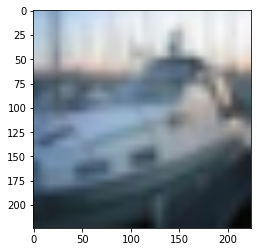

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(np.transpose(selected_orig, (1, 2, 0)))

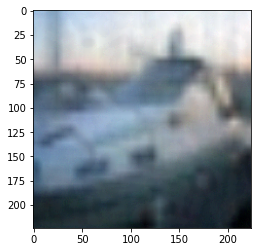

In [ ]:
plt.imshow(np.transpose(selected_adv, (1, 2, 0)))

2020-11-10 04:20:36,594 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


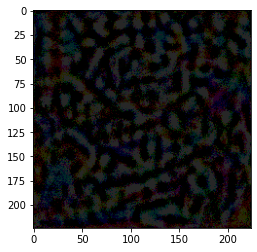

In [ ]:
plt.imshow(10*(np.transpose(selected_orig, (1, 2, 0)) - np.transpose(selected_adv, (1, 2, 0))))

Experiment PGD attacks

In [ ]:
for i in range(len(pgd_epsilon)):
  attack = FastGradientMethod(estimator=classifier, eps=fgm_epsilon[i])
  Acc = []
  for batch_idx, (X, Y) in enumerate(testloader):
    x_test = X.numpy()
    y_test = Y.numpy()
    x_test_adv = attack.generate(torch.from_numpy(x_test))
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.array(y_test)) / len(y_test)
    Acc.append(accuracy)
    logging.info('accuracy: {}'.format(accuracy))
  
  logging.info("Accuracy for eps={}: {}".format(fgm_epsilon[i], np.mean(np.array(Acc))))

  pred_list = np.asanyarray(Acc)
  idx = np.arange(0,len(testset)/test_batchsize).tolist()
  dict = {'Id': idx ,'acc': pred_list} 
  df = pd.DataFrame(dict) 
  # saving the dataframe 
  df.to_csv('./gdrive/My Drive/IDL_Project/results/FGM_result_eps{}_{}.csv'.format(fgm_epsilon[i], datetime.datetime.now()),index=False)